In [1937]:
import pandas as pd
import numpy as np
import os
from scipy import signal
import statsmodels
from scipy.stats import norm
from math import factorial
import time
from scipy import stats
import scipy as scipy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.6f}'.format
np.set_printoptions(threshold=5)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

European Options

In [1671]:
def Black_Scholes(S,K,sigma,r,y,T, PutCall):
    
    x = (np.log(S/K)+(r-y+sigma**2/2)*T)/(sigma*np.sqrt(T))
    x_ = x - sigma*np.sqrt(T)

    return PutCall*(S*np.exp(-y*T)*norm.cdf(PutCall*x) - K*np.exp(-r*T)*norm.cdf(PutCall*x_))

In [1672]:
def Monte_Carlo_European(S,K,sigma,r,y,T, PutCall, samples = 100000, periods = 10):
    
    rand = np.random.normal(size = samples)
    S_T = S*np.exp((r-y-sigma**2/2)*T + rand*np.sqrt(T)*sigma) 
    
#     rand = np.random.normal(size = (samples, periods))
#     each_period = T/periods
#     S_T = S*np.cumprod(np.exp((r-y-sigma**2/2)*each_period + rand*np.sqrt(each_period)*sigma), 1)[:,-1]
    
    return np.mean(np.exp(-r*T)*np.maximum(PutCall*(S_T - K), [0]*samples))

In [1673]:
S=100.0    
K=100.0     
T=1 
r=0.1       
sigma=0.2    
y = 0 
print (Black_Scholes(S,K,sigma,r,y,T, PutCall=1), Black_Scholes(S,K,sigma,r,y,T, PutCall=-1))
print (Monte_Carlo_European(S,K,sigma,r,y,T, PutCall=1), Monte_Carlo_European(S,K,sigma,r,y,T, PutCall=-1))

13.269676584660893 3.753418388256833
13.278374971834532 3.751921549874204


American Options

In [1674]:
def Monte_Carlo_Hack(S,K,sigma,r,y,T, PutCall_Tmp, samples = 1000, periods = 100):
    
    global option_price
    rand = np.random.normal(size = (samples, periods))
    each_period = T/periods
    S_T = S*np.cumprod(np.exp((r-y-sigma**2/2)*each_period + rand*np.sqrt(each_period)*sigma), 1)
    
    final_excercise_price = np.maximum(PutCall_Tmp*(S_T[:,periods - 1]- K), [0]*samples)
    option_price = np.zeros(((samples, periods,)))
    checks = np.zeros(((samples, periods,)))
    option_price[:,periods - 1] = final_excercise_price
  
    for this_period in reversed(range(0, periods - 1)):
        excercise_value = PutCall_Tmp*(S_T[:,this_period] - K)
        continuation_value  = []
        for this_sample in range(samples):
            continuation_value.append(\
            Monte_Carlo_European(S_T[this_sample,this_period],K,sigma,r,y,\
                                 T*(1 - this_period/periods) - each_period, PutCall_Tmp))
        time_value = np.mean(continuation_value)
        option_price[:,this_period] =  np.maximum(excercise_value, time_value)
        checks[:,this_period] =  time_value > excercise_value 
        
    return np.exp(-r*each_period)*(option_price[:,0].mean())

In [1675]:
# S=100.0    
# K=100.0     
# T=1 
# r=0.1       
# sigma=0.2    
# y = 0 
# print (Monte_Carlo_Hack(S,K,sigma,r,y,T, PutCall_Tmp=1), Monte_Carlo_Hack(S,K,sigma,r,y,T, PutCall_Tmp=-1))

In [1676]:
def Binomial(S, K, sigma, r, y, T, PutCall, periods = 100):  
    
    each_period = T/periods
    u = np.exp(sigma*np.sqrt(each_period))
    d = 1/u
    p = (np.exp(r*each_period)-d) / (u-d) 

    #Binomial price tree
    stockvalue = np.zeros((periods+1,periods+1))
    stockvalue[0,0] = S
    for i in range(1,periods+1):
        stockvalue[i,0] = stockvalue[i-1,0]*u
        for j in range(1,i+1):
            stockvalue[i,j] = stockvalue[i-1,j-1]*d
    
    #option value at final node   
    optionvalue = np.zeros((periods+1,periods+1))
    for j in range(1,periods+1):
        optionvalue[periods,j] = max(0, PutCall*(stockvalue[periods,j]-K))

    #backward calculation for option price    
    for i in range(periods-1,-1,-1):
        for j in range(i+1):
            optionvalue[i,j] = max(max(0, PutCall*(stockvalue[i,j]-K)), \
                                           np.exp(-r*each_period)*(p*optionvalue[i+1,j]+(1-p)*optionvalue[i+1,j+1]))
    
    return optionvalue[0,0]

In [1677]:
S=100.0    
K=100.0     
T=1 
r=0.1       
sigma=0.2    
y = 0 
print (Binomial(S,K,sigma,r,y,T, PutCall=1), Binomial(S,K,sigma,r,y,T, PutCall=-1))

13.248820796590946 4.808610311562316


In [1678]:
def Longstaff_Schwartz(S,K,sigma,r,y,T, PutCall, samples = 100000, periods = 1000):
        
    rand = np.random.normal(size = (samples, periods))
    each_period = T/periods
    S_T = np.append(S*np.ones((1,samples)).T, \
                    S*np.cumprod(np.exp((r-y-sigma**2/2)*each_period + rand*np.sqrt(each_period)*sigma), 1), axis=1)

    final_excercise_price = np.maximum(PutCall*(S_T[:,periods] - K), [0]*samples)
    call_price = np.zeros(((samples, periods + 1,)))
    call_price[:,periods] = final_excercise_price
    call_price2 = np.copy(call_price)
    continuation_value_df = np.zeros(((samples, periods + 1,)))
    excercise_value_df = np.zeros(((samples, periods + 1,)))
    
    for this_period in (range(periods - 1, 0 , -1)):

        excercise_possibility = (PutCall*(S_T[:,this_period] - K)) > 0
        rhs = S_T[:,this_period]*excercise_possibility
        lhs = np.exp(-r*each_period)*call_price[:,(this_period + 1)]*excercise_possibility
        reg = np.polyfit(x =rhs, y=lhs, deg=4)  
        continuation_value = np.polyval(p=reg, x=S_T[:,this_period])*excercise_possibility 
        excercise_value = np.maximum(PutCall*(S_T[:,this_period] - K), [0]*samples)*excercise_possibility
        
        call_price[:,this_period] = np.where(excercise_value > continuation_value, excercise_value,
                                               call_price[:,this_period + 1] * np.exp(-r*each_period))
        call_price2[:,this_period] = call_price2[:,this_period + 1] * np.exp(-r*each_period)
        continuation_value_df[:,this_period] = continuation_value
        excercise_value_df[:,this_period] = excercise_value
       
    price = np.exp(-r*each_period)*np.average(call_price[:, 1])
    price2 = np.exp(-r*each_period)*np.average(call_price2[:, 1])
    
    print (price, price2)

In [1679]:
# S=110.0    
# K=100.0     
# T=1 
# r=0.1       
# sigma=0.2    
# y = 0 
# print (Longstaff_Schwartz(S,K,sigma,r,y,T, PutCall=1), Longstaff_Schwartz(S,K,sigma,r,y,T, PutCall=-1))

In [1680]:
def payoff_f(S, PutCall):
    
    if PutCall==1:
        Payoff = np.maximum(S - K, 0)
    elif PutCall==-1:    
        Payoff = np.maximum(K - S, 0)  
        
    return Payoff

In [1681]:
def PDE_price(S,K,sigma,r,y,T, PutCall, steps, solver="splu", exercise="American"):

    Nspace = steps[0]   
    Ntime = steps[1]

    S_max = 4*float(K)                
    S_min = float(K)/4
    x_max = np.log(S_max)
    x_min = np.log(S_min)
    x0 = np.log(S)                            

    x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  
    t, dt = np.linspace(0, T, Ntime, retstep=True)        
    Payoff = payoff_f(np.exp(x), PutCall)

    V = np.zeros((Nspace,Ntime))
    if PutCall==1:
        V[:,-1] = Payoff
        V[-1,:] = np.exp(x_max)
        V[0,:]  = 0
    else:    
        V[:,-1] = Payoff
        V[-1,:] = 0
        V[0,:]  = K   
            
    sig2 = sig**2 
    dxx = dx**2
    theta = 0.5 
    a1 = ((1 - theta) * (dt/2) * ((r-0.5*sig2)/dx - sig2/dxx ))
    b1 = (1 + (1 - theta) * dt * (sig2/dxx + r))
    c1 = (-(1 - theta) * (dt/2) * ((r-0.5*sig2)/dx + sig2/dxx ))
    D1 = sparse.diags([a1, b1, c1], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
 
    a2 = (- (theta) * (dt/2) * ((r-0.5*sig2)/dx - sig2/dxx ))
    b2 = (1 - (theta) * dt * (sig2/dxx + r))
    c2 = ((theta) * (dt/2) * ((r-0.5*sig2)/dx + sig2/dxx ))
    D2 = sparse.diags([a2, b2, c2], [-1, 0, 1], shape=(Nspace-2, Nspace-2))
    offset = np.zeros(Nspace-2)

    if solver == "splu":
        if exercise=="European":        
            for i in range(Ntime-2,-1,-1):                   
                offset[0] = a1 * V[0,i]
                offset[-1] = c1 * V[-1,i]
                v_tmp = V[1:-1,i+1] - offset
                P, L, U = linalg.lu((D1.toarray()))
                x1 = linalg.solve(L, D2*v_tmp)
                x2 = linalg.solve(U, x1)
                V[1:-1,i] = x2  
                
        elif exercise=="American":
            for i in range(Ntime-2,-1,-1):                
                offset[0] = a1 * V[0,i]
                offset[-1] = c1 * V[-1,i]
                v_tmp = V[1:-1,i+1] - offset
                penalty_diag = np.diag([100000000000 if Payoff[1:-1][k] > v_tmp[k] else 0 for k in range(len(v_tmp))])
                P, L, U = linalg.lu(D1.toarray() + penalty_diag)
                x1 = linalg.solve(L, D2*v_tmp + np.dot(penalty_diag, Payoff[1:-1]))
                x2 = linalg.solve(U, x1)
                V[1:-1,i] = x2 
                   

    price = np.interp(x0, x, V[:,0])
    price_vec = V[:,0]
    mesh = V

    return price

In [1682]:
S=100.0    
K=100.0     
T=1 
r=0.1       
sigma=0.2    
y = 0 
print (PDE_price(S,K,sigma,r,y,T, PutCall=1, steps = (250,200)))
print (PDE_price(S,K,sigma,r,y,T, PutCall=-1, steps = (250,200)))

13.273352948308954
4.81728638870671


In [1705]:
def PIDE_price(S,K,sigma,r,y,T, lam, muJ, sigJ, PutCall=1, steps = (250,200), solver="splu", exercise="American"):

    Nspace = steps[0]   
    Ntime = steps[1]

    S_max = 6*float(K)                
    S_min = float(K)/6
    x_max = np.log(S_max)
    x_min = np.log(S_min)
    t, dt = np.linspace(0, T, Ntime, retstep=True)       

    dx = (x_max - x_min)/(Nspace-1)
    dev_X = np.sqrt(lam*dt*sigJ**2 + lam*dt*muJ**2)
    extraP = int(np.floor(5*dev_X/(dx*dt))) 
    x = np.linspace(x_min-extraP*dx, x_max+extraP*dx, Nspace + 2*extraP)   

    Payoff = payoff_f(np.exp(x), PutCall)
    offset = np.zeros(Nspace-2)                 
    V = np.zeros((Nspace + 2*extraP, Ntime))       
                 
    if PutCall==1:
        V[:,-1] = Payoff                    
        V[-extraP-1:,:] = np.exp(x[-extraP-1:]).reshape(extraP+1,1) * np.ones((extraP+1,Ntime)) 
        V[:extraP+1,:] = 0
    else:    
        V[:,-1] = Payoff
        V[-extraP-1:,:] = 0
        V[:extraP+1,:] = K * np.ones((extraP+1,Ntime))                       

    cdf = ss.norm.cdf([np.linspace(-(extraP+1+0.5)*dx, (extraP+1+0.5)*dx, 2*(extraP+2) )], loc=muJ, scale=sigJ)[0]
    nu = lam * (cdf[1:] - cdf[:-1])        

    m_jumps = lam * (np.exp(muJ + (sigJ**2)/2) -1)
    sig2 = sig**2 
    dxx = dx**2
    
    theta = 0.5 
    a1 = ((1 - theta) * (dt/2) * ((r-m_jumps -0.5*sig2)/dx - sig2/dxx ))
    b1 = (1 + (1 - theta) * dt * (sig2/dxx + r + lam))
    c1 = (-(1 - theta) * (dt/2) * ((r-m_jumps -0.5*sig2)/dx + sig2/dxx ))
    D1 = sparse.diags([a1, b1, c1], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
 
    a2 = (- (theta) * (dt/2) * ((r- m_jumps -0.5*sig2)/dx - sig2/dxx ))
    b2 = (1 - (theta) * dt * (sig2/dxx + r + lam))
    c2 = ((theta) * (dt/2) * ((r-m_jumps -0.5*sig2)/dx + sig2/dxx ))
    D2 = sparse.diags([a2, b2, c2], [-1, 0, 1], shape=(Nspace-2, Nspace-2))
    offset = np.zeros(Nspace-2)
    
    
    if exercise=="European":        
        for i in range(Ntime-2,-1,-1):
            offset[0] = a1 * V[extraP,i]
            offset[-1] = c1 * V[-1-extraP,i]
            v_tmp = V[extraP+1 : -extraP-1, i+1] + dt * signal.convolve(V[:,i+1],nu[::-1],mode="valid",method="fft") - offset
            P, L, U = linalg.lu((D1.toarray()))
            x1 = linalg.solve(L, D2*v_tmp)
            x2 = linalg.solve(U, x1)
            V[extraP+1 : -extraP-1, i]  = x2 
                
    
    elif exercise=="American":
        for i in range(Ntime-2,-1,-1):
                
            offset[0] = a1 * V[extraP,i]
            offset[-1] = c1 * V[-1-extraP,i]
            v_tmp = V[extraP+1 : -extraP-1, i+1] + dt * signal.convolve(V[:,i+1],nu[::-1],mode="valid",method="fft") - offset
            penalty_diag = np.diag([1000000000 if Payoff[extraP+1:-extraP-1][k] > v_tmp[k] else 0 for k in range(len(v_tmp))])
            P, L, U = linalg.lu(D1.toarray() + penalty_diag)
            x1 = linalg.solve(L, D2*v_tmp + np.dot(penalty_diag, Payoff[extraP+1 : -extraP-1]))
            x2 = linalg.solve(U, x1)
            V[extraP+1 : -extraP-1, i] = x2 
                

    X0 = np.log(S0)                           
    S_vec = np.exp(x[extraP+1 : -extraP-1])        
    price = np.interp(X0, x, V[:,0])
    price_vec = V[extraP+1 : -extraP-1,0]
    mesh = V[extraP+1 : -extraP-1, :]

    return price

In [1706]:
S=100.0    
K=100.0     
T=1 
r=0.1       
sigma=0.2    
y = 0 
lam = 0.8  
muJ = 0   
sigJ = 0.5
print (PIDE_price(S,K,sigma,r,y,T, lam, muJ, sigJ,  PutCall=1, steps = (250,200)))
print (PIDE_price(S,K,sigma,r,y,T, lam, muJ, sigJ,  PutCall=-1, steps = (250,200)))

22.24676188046628
13.011975033884578


In [1691]:
def jump_closed_formula(S,K,sigma,r,y,T, lam, muJ, sigJ, PutCall=1):

    m = lam * (np.exp(muJ + (sigJ**2)/2) -1)    
    lam2 = lam * np.exp(muJ + (sigJ**2)/2)

    tot=0
    for i in range(20):
        tot += ( np.exp(-lam2*T) * (lam2*T)**i / factorial(i) ) \
        * Black_Scholes(S, K, np.sqrt(sig**2 + (i*sigJ**2)/T), r-m+i*(muJ+0.5*sigJ**2)/T, y, T, PutCall)  
    
    return tot

In [1692]:
S=100.0    
K=100.0     
T=1 
r=0.1       
sigma=0.2    
y = 0 
lam = 0.8  
muJ = 0   
sigJ = 0.5
print (jump_closed_formula(S,K,sigma,r,y,T, lam, muJ, sigJ,  PutCall=1))
print (jump_closed_formula(S,K,sigma,r,y,T, lam, muJ, sigJ,  PutCall=-1))

22.0163676219057
12.50010942550166


Stock, Vol, IR Model

In [2042]:
def Heston_process(s0, v0, T, rho = -0.5, mu=0.1, sigma=0.2, theta=0.5, kappa=0.1, Nsteps=252, Nsim=1000, seed=None):
            
    global simulated_paths_stocks, simulated_paths_vol
    
    simulated_paths_stocks = np.zeros([Nsim, Nsteps+1])
    simulated_paths_vol = np.zeros([Nsim, Nsteps+1])
    simulated_paths_stocks[:,0] = np.log(s0)
    simulated_paths_vol[:,0] = v0
    
    T_vec, Delta_t = np.linspace(0, T, Nsteps,retstep=True)
    
    MU = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    W = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=[Nsim, Nsteps])
    W = pd.Panel(W).swapaxes(2, 0).swapaxes(1, 2)
    Z_1 = np.array(W[0])
    Z_2 = np.array(W[1])
        
    for t in range(Nsteps):
        simulated_paths_vol[:,t+1] = np.abs(simulated_paths_vol[:,t] + \
                                kappa*(theta - simulated_paths_vol[:,t])*Delta_t + \
                                sigma*np.sqrt(simulated_paths_vol[:,t])*np.sqrt(Delta_t)*Z_1[:,t])      
        
        simulated_paths_stocks[:,t+1] = simulated_paths_stocks[:,t] + \
                                 (mu - 0.5*simulated_paths_vol[:,t])*Delta_t + \
                                 np.sqrt(simulated_paths_vol[:,t])*np.sqrt(Delta_t)*Z_2[:,t]
        
    final_vol = simulated_paths_vol[:,-1]
    final_stock = simulated_paths_stocks[:,-1]
    
    mean_analytical = v0*np.exp(-kappa*T) + theta*(1 - np.exp(-kappa*T))
    var_analytical = (v0*sigma**2/kappa)*(np.exp(-kappa*T) - np.exp(-2*kappa*T)) + \
                     (theta*sigma**2/(2*kappa))*((1 - np.exp(-kappa*T))**2)
    mean_vol = np.mean(final_vol)
    var_vol = np.std(final_vol)**2
    
    print('Corr:' , \
          pd.DataFrame(simulated_paths_stocks).pct_change().T.corrwith(pd.DataFrame(simulated_paths_vol).diff().T).mean())   
    print("Analytical Mean", mean_analytical)
    print("Analytical Var", var_analytical)
    print("Mean", mean_vol)
    print("Var", var_vol)
    
    print("Heston's Vol Model")
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1) * Nsteps
    heston_volatility = ax.plot(t, simulated_paths_vol.transpose());
    plt.setp(heston_volatility, linewidth=1);
    ax.set(xlabel='Time (days)', ylabel='Volatility')
    plt.show()
    
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1) * Nsteps
    heston_volatility = ax.plot(t, simulated_paths_stocks.transpose());
    plt.setp(heston_volatility, linewidth=1);
    ax.set(xlabel='Time (days)', ylabel='Stock')
    plt.show()

Corr: -0.45638437914748753
Analytical Mean 0.17250769876880728
Analytical Var 0.00922228226966126
Mean 0.16694573662574044
Var 0.009155409447369842
Heston's Vol Model


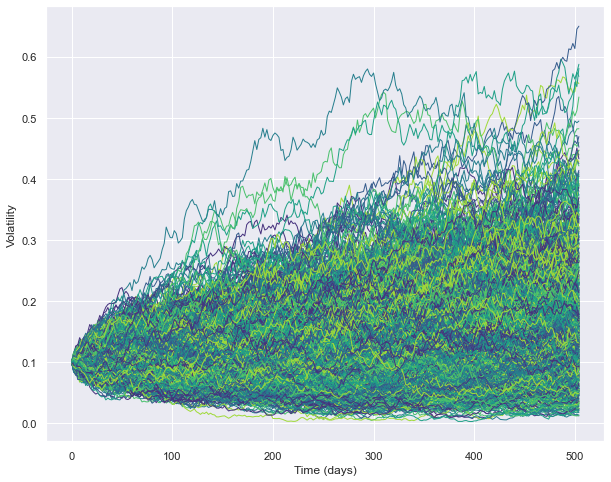

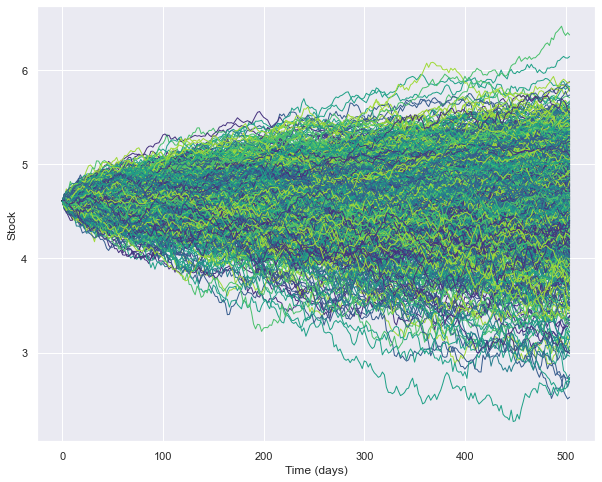

In [2044]:
Heston_process(100, 0.1, 2)

In [1978]:
def jump_diffusion(S=1, T=1, mu=0.12, sigma=0.3, Lambda=0.25,
                   a=0, b=0.2, Nsteps=252, Nsim=10000, alpha=0.05, seed=None):

    np.random.seed(seed)
    
    Delta_t = T/Nsteps

    mean_Y = np.exp(a + 0.5*(b**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    simulated_paths = np.zeros([Nsim, Nsteps+1])
    simulated_paths[:,0] = S

    Z_1 = np.random.normal(size=[Nsim, Nsteps])
    Z_2 = np.random.normal(size=[Nsim, Nsteps])
    Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu
                               - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t)* Z_1[:,i]
                             + a*Poisson[:,i] + np.sqrt(b**2) * np.sqrt(Poisson[:,i])*Z_2[:,i])
        
#         simulated_paths[:,i+1] = simulated_paths[:,i] + \
#                                  mu*simulated_paths[:,i]*Delta_t + \
#                                  sigma*simulated_paths[:,i]*np.sqrt(Delta_t)*Z_1[:,i]
        

    final_prices = simulated_paths[:,-1]
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    std_jump = np.std(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)

    # Calculate confidence interval for the mean
    ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
    ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

    # Print statistics, align results
    print("Merton's Jump Diffusion Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(M))
    print('Variance (V){:>17.4f}'.format(V))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Standard deviation {:>10.4f}'.format(std_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
    print('\nConfidence interval, Mean')
    print('-----------------------------')
    print('Alpha {:>23.2f}'.format(alpha))
    print('Lower bound {:>17.4f}'.format(ci_low))
    print('Upper bound {:>17.4f}'.format(ci_high))

    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()

    # Generate t, the time variable on the abscissae
    t = np.linspace(0, T, Nsteps+1) * Nsteps

    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion = ax.plot(t, simulated_paths.transpose());

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated stock price paths in Merton's jump diffusion model\n \
            $S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
            $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
           xlabel='Time (days)', ylabel='Stock price')

    # Display figure in a Python environment
    plt.show()
    
    mean = (mu - 0.5*(sigma**2))*T + Lambda*T*a
    stddev = np.sqrt(sigma**2*T + + Lambda*T*(b**2 + a**2))
    lognormal_dist = pd.DataFrame(np.random.lognormal(mean, stddev, 10000))

    data = pd.DataFrame(final_prices)
    plt.hist(lognormal_dist, bins = 100, weights=np.ones(len(lognormal_dist)) / len(lognormal_dist), \
             label = 'Theoritical Log Normal')
    plt.hist(data, bins = 100, weights=np.ones(len(data)) / len(data), label = 'Simulated Jump Diffusion')
    plt.title('PDF of end prices')
    plt.legend()
    plt.show()

Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               1.1275
Variance (V)           0.1197

Monte Carlo Estimates
-----------------------------
Mean                   1.1284
Variance               0.1282
Standard deviation     0.3581
Skewness               0.9075
Excess kurtosis        1.1138

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound            1.1062
Upper bound            1.1506


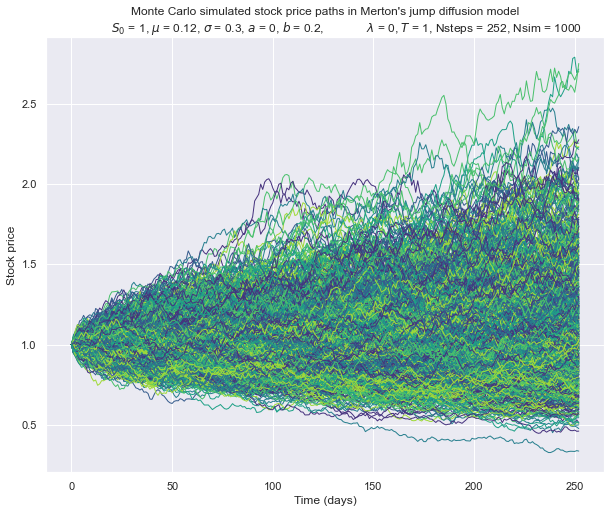

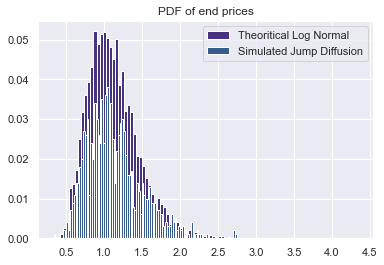

In [1893]:
jump_diffusion(S=1, T=1, mu=0.12, sigma=0.3, Lambda=0,
                   a=0, b=0.2, Nsteps=252, Nsim=1000, alpha=0.05, seed=None)

In [2157]:
def VG_model(s0, T, r=0.1, sigma=0.2, theta=0.1, kappa=0.1, Nsteps=252, Nsim=10000, seed=None):
    
    mean = theta*T
    var = sigma**2*T + theta**2*kappa*T 
    skew = (2*theta**3*kappa**2 + 3*sigma**2*theta*kappa)*T/(var**(1.5)) 
    kurt = (3*sigma**4*kappa +12*sigma**2*theta**2*kappa**2 + 6*theta**4*kappa**3)*T/(var**2)

    simulated_paths = np.zeros([Nsim, Nsteps+1])
    simulated_paths[:,0] = s0
    T_vec, Delta_t = np.linspace(0, T, Nsteps,retstep=True)
    
    Z_1 = ss.norm.rvs(loc=0, scale=1, size=[Nsim, Nsteps])
    G_1 = ss.gamma(Delta_t/kappa,scale=kappa).rvs(size=[Nsim, Nsteps])    
    w = - np.log(1 - theta*kappa - kappa/2*sigma**2)/kappa
    
    for i in range(Nsteps):
        simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((r - w)*Delta_t + \
                                                             theta*G_1[:,i] + sigma*np.sqrt(G_1[:,i])*Z_1[:,i])    
    
    final_prices = np.log(simulated_paths[:,-1]/simulated_paths[:,0])
    mean_jump = np.mean(final_prices)
    var_jump = np.var(final_prices)
    skew_jump = stats.skew(final_prices)
    kurt_jump = stats.kurtosis(final_prices)

    # Print statistics, align results
    print("VG Model")
    print('-----------------------------')
    print('Theoretical Moments')
    print('-----------------------------')
    print('Mean (M){:>21.4f}'.format(mean))
    print('Variance (V){:>17.4f}'.format(var))
    print('Skew (V){:>21.4f}'.format(skew))
    print('Kurt (V){:>21.4f}'.format(kurt))
    print('\nMonte Carlo Estimates')
    print('-----------------------------')
    print('Mean {:>24.4f}'.format(mean_jump))
    print('Variance {:>20.4f}'.format(var_jump))
    print('Skewness {:>20.4f}'.format(skew_jump))
    print('Excess kurtosis {:>13.4f}'.format(kurt_jump))

    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    t = np.linspace(0, T, Nsteps+1) * Nsteps
    heston_volatility = ax.plot(t, simulated_paths.transpose());
    plt.setp(heston_volatility, linewidth=1);
    ax.set(xlabel='Time (days)', ylabel='Stock')
    plt.show()

VG Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)               0.2000
Variance (V)           0.0820
Skew (V)               0.1039
Kurt (V)               0.1572

Monte Carlo Estimates
-----------------------------
Mean                   0.1637
Variance               0.0822
Skewness               0.0812
Excess kurtosis        0.1679


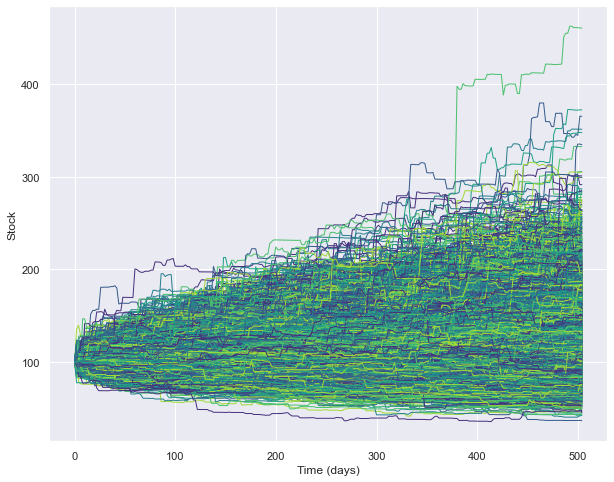

In [2158]:
VG_model(s0 = 100,T = 2)

Stock Model Estimate

In [2448]:
data = np.random.normal(1, 10, 1000) + np.random.normal(0.5, 2, 1000)

def mle(parameters):
    
    mu    = parameters[0]
    sigma = parameters[1]    
    n     = len(data)  
    
    L = 0 
    for data_ in data:
        L = L + 1/(2*sigma**2)*(data_ - mu)**2
    L = L + (n/2)*np.log(2*np.pi) + (n/2)*np.log(sigma**2)
    
    return L

def gmm(parameters):
    
    mu    = parameters[0]
    sigma = parameters[1]
    M1 = mu - data.mean()
    M2 = sigma - data.std()
    moments = np.array([M1 , M2])
    W = np.zeros((len(moments), len(moments))); np.fill_diagonal(W, 1)

    L = np.dot(np.dot(np.transpose(moments), W), moments)

    return L 

print(scipy.optimize.minimize(mle, x0 = [0, 1], hess = '3-point’'))
print(scipy.optimize.minimize(gmm, x0 = [0, 1]))

      fun: 3764.097895832346
 hess_inv: array([[0.24667764, 0.04472124],
       [0.04472124, 0.01502996]])
      jac: array([ 0.00000000e+00, -3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 190
      nit: 25
     njev: 60
   status: 2
  success: False
        x: array([ 1.28085069, 10.43493086])
      fun: 1.7276867024749438e-12
 hess_inv: array([[ 0.99095184, -0.0666499 ],
       [-0.0666499 ,  0.50904816]])
      jac: array([-2.59141649e-06,  3.58201447e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([ 1.28085002, 10.43493571])


ADI

In [1896]:
from math import sinh, asinh
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv
from datetime import datetime
from scipy.sparse import csc_matrix
import numpy as np
from math import exp

In [2431]:
# parameters
K = 100
S_0 = 100
S = 8*K
V_0 = 0.04
V = 5
T = 1
r_d = 0.025                                 # domestic interest rate
r_f = 0                                    # foreign interest rate
rho = -0.9
sigma = 0.3
kappa = 1.5
eta = 0.04
true_price = 8.8948693600540167             # from Monte Carlo simulation (ref: https://github.com/RedwanBouizi/MC-Heston)
m1 = 10                                     # S
m2 = 4                                     # V
m = (m1 + 1) * (m2 + 1)                     # matrix A and vector U size
c = K/5
d = V/500

N = 20
delta_t = T / N

In [2432]:
def Map_s(xi, K, c):
    return K + c * sinh(xi)

def Map_v(xi, d):
    return d * sinh(xi)

def make_grid(m1, S, S_0, K, c, m2, V, V_0, d):
    #find x_max such that g(x_max) = X_MAX that you would want; Divide (0, x_max) into equal pieces  
    Delta_xi = (1.0 / m1) * (asinh((S - K) / c) - asinh(-K / c))
    #now convert (0, x_max) to g(0) to g(x_max)
    Uniform_s = [asinh(-K / c) + i * Delta_xi for i in range(m1 + 1)]
    Vec_s = [Map_s(Uniform_s[i], K, c) for i in range(m1 + 1)]
    Vec_s.append(S_0)
    Vec_s.sort()
    Vec_s.pop(-1)
    Delta_s = [Vec_s[i + 1] - Vec_s[i] for i in range(m1)]

    Delta_eta = (1.0 / m2) * asinh(V / d)
    Uniform_v = [i * Delta_eta for i in range(m2 + 1)]
    Vec_v = [Map_v(Uniform_v[i], d) for i in range(m2 + 1)]
    Vec_v.append(V_0)
    Vec_v.sort()
    Vec_v.pop(-1)
    Delta_v = [Vec_v[i + 1] - Vec_v[i] for i in range(m2)]

    X, Y = np.meshgrid(Vec_s, Vec_v)
    
    plt.plot(X, Y, '.', color='blue')
    plt.show()

    return Vec_s, Delta_s, Vec_v, Delta_v, X, Y

In [2434]:
def delta_s(i, pos, Delta_s):
    if pos == -1:
        return 2 / (Delta_s[i] * (Delta_s[i] + Delta_s[i + 1]))
    elif pos == 0:
        return -2 / (Delta_s[i] * Delta_s[i + 1])
    elif pos == 1:
        return 2 / (Delta_s[i + 1] * (Delta_s[i] + Delta_s[i + 1]))
    else:
        raise ValueError("Wrong pos")


def delta_v(i, pos, Delta_v):
    if pos == -1:
        return 2 / (Delta_v[i] * (Delta_v[i] + Delta_v[i + 1]))
    elif pos == 0:
        return -2 / (Delta_v[i] * Delta_v[i + 1])
    elif pos == 1:
        return 2 / (Delta_v[i + 1] * (Delta_v[i] + Delta_v[i + 1]))
    else:
        raise ValueError("Wrong pos")


def alpha_s(i, pos, Delta_s):
    if pos == -2:
        return Delta_s[i] / (Delta_s[i - 1] * (Delta_s[i - 1] + Delta_s[i]))
    elif pos == -1:
        return (-Delta_s[i - 1] - Delta_s[i]) / (Delta_s[i - 1] * Delta_s[i])
    elif pos == 0:
        return (Delta_s[i - 1] + 2 * Delta_s[i]) / (Delta_s[i] * (Delta_s[i - 1] + Delta_s[i]))
    else:
        raise ValueError("Wrong pos")


def alpha_v(i, pos, Delta_v):
    if pos == -2:
        return Delta_v[i] / (Delta_v[i - 1] * (Delta_v[i - 1] + Delta_v[i]))
    elif pos == -1:
        return (-Delta_v[i - 1] - Delta_v[i]) / (Delta_v[i - 1] * Delta_v[i])
    elif pos == 0:
        return (Delta_v[i - 1] + 2 * Delta_v[i]) / (Delta_v[i] * (Delta_v[i - 1] + Delta_v[i]))
    else:
        raise ValueError("Wrong pos")


def beta_s(i, pos, Delta_s):
    if pos == -1:
        return -Delta_s[i + 1] / (Delta_s[i] * (Delta_s[i] + Delta_s[i + 1]))
    elif pos == 0:
        return (Delta_s[i + 1] - Delta_s[i]) / (Delta_s[i] * Delta_s[i + 1])
    elif pos == 1:
        return Delta_s[i] / (Delta_s[i + 1] * (Delta_s[i] + Delta_s[i + 1]))
    else:
        raise ValueError("Wrong pos")


def beta_v(i, pos, Delta_v):
    if pos == -1:
        return -Delta_v[i + 1] / (Delta_v[i] * (Delta_v[i] + Delta_v[i + 1]))
    elif pos == 0:
        return (Delta_v[i + 1] - Delta_v[i]) / (Delta_v[i] * Delta_v[i + 1])
    elif pos == 1:
        return Delta_v[i] / (Delta_v[i + 1] * (Delta_v[i] + Delta_v[i + 1]))
    else:
        raise ValueError("Wrong pos")


def gamma_s(i, pos, Delta_s):
    if pos == 0:
        return (-2 * Delta_s[i + 1] - Delta_s[i + 2]) / (Delta_s[i + 1] * (Delta_s[i + 1] + Delta_s[i + 2]))
    elif pos == 1:
        return (Delta_s[i + 1] + Delta_s[i + 2]) / (Delta_s[i + 1] * Delta_s[i + 2])
    elif pos == 2:
        return -Delta_s[i + 1] / (Delta_s[i + 2] * (Delta_s[i + 1] + Delta_s[i + 2]))
    else:
        raise ValueError("Wrong pos")


def gamma_v(i, pos, Delta_v):
    if pos == 0:
        return (-2 * Delta_v[i + 1] - Delta_v[i + 2]) / (Delta_v[i + 1] * (Delta_v[i + 1] + Delta_v[i + 2]))
    elif pos == 1:
        return (Delta_v[i + 1] + Delta_v[i + 2]) / (Delta_v[i + 1] * Delta_v[i + 2])
    elif pos == 2:
        return -Delta_v[i + 1] / (Delta_v[i + 2] * (Delta_v[i + 1] + Delta_v[i + 2]))
    else:
        raise ValueError("Wrong pos")

In [2439]:
def make_matrices(m1, m2, m, rho, sigma, r_d, r_f, kappa, eta, Vec_s, Vec_v, Delta_s, Delta_v):
    
    A_0 = np.zeros((m, m))
    A_1 = np.zeros((m, m))
    A_2 = np.zeros((m, m))

    l_9a = [-2, -1, 0]
    l_9b = [-1, 0, 1]
    l_9c = [0, 1, 2]
    l_10 = [-1, 0, 1]
    l_11 = [[-1, 0, 1], [-1, 0, 1]]

    # Definition of A_0
    for j in range(1, m2):
        for i in range(1, m1):
            c = rho * sigma * Vec_s[i] * Vec_v[j]
            for k in l_11[0]:
                for l in l_11[1]:
                    A_0[i + j * (m1 + 1), (i + k) + (j + l) * (m1 + 1)] += c * beta_s(i - 1, k, Delta_s) * \
                    beta_v(j - 1, l, Delta_v)

    A_0 = csc_matrix(A_0)
#     plt.spy(A_0)
#     plt.show()

    # Definition of A_1
    for j in range(m2 + 1):
        for i in range(1, m1):
            a = 0.5 * Vec_s[i] ** 2 * Vec_v[j]
            b = (r_d - r_f) * Vec_s[i]
            for k in l_10:
                A_1[i + j * (m1 + 1), (i + k) + j * (m1 + 1)] += (a * delta_s(i - 1, k, Delta_s) + \
                                                                  b * beta_s(i - 1, k, Delta_s))
            A_1[i + j * (m1 + 1), i + j * (m1 + 1)] += - 0.5 * r_d
        A_1[m1 + j * (m1 + 1), m1 + j * (m1 + 1)] += - 0.5 * r_d


    A_1 = csc_matrix(A_1)
#     plt.spy(A_1[:20,:20])
#     plt.show()

    #Definition of A_2
    for j in range(m2 - 1):
        for i in range(m1 + 1):
            temp = kappa * (eta - Vec_v[j])
            temp2 = 0.5 * sigma ** 2 * Vec_v[j]
            if Vec_v[j] > 1.:
                for k in l_9a:
                    A_2[i + (j + 1) * (m1 + 1), i + (m1 + 1) * (j + 1 + k)] += temp * alpha_v(j, k, Delta_v)
                for k in l_10:
                    A_2[i + (j + 1) * (m1 + 1), i + (m1 + 1) * (j + 1 + k)] += temp2 * delta_v(j - 1, k, Delta_v)
            if j == 0:
                for k in l_9c:
                    A_2[i, i + (m1 + 1) * k] += temp * gamma_v(j, k, Delta_v)
            else:
                for k in l_10:
                    A_2[i + j * (m1 + 1), i + (m1 + 1) * (j + k)] += (temp * beta_v(j - 1, k, Delta_v) + \
                                                                      temp2 * delta_v(j - 1, k, Delta_v))
            A_2[i + j * (m1 + 1), i + j * (m1 + 1)] += - 0.5 * r_d

    A_2 = csc_matrix(A_2)
#     plt.spy(A_2[:,:])
#     plt.show()

    A = A_0 + A_1 + A_2
    A = csc_matrix(A)
    #plt.spy(A)
    #plt.show()

    return A_0, A_1, A_2, A


def make_boundaries(m1, m2, m, r_d, r_f, N, Vec_s, delta_t):
    b_0 = [0.] * m
    b_1 = [0.] * m
    b_2 = [0.] * m

    # Boundary when s = S
    for j in range(m2 + 1):
        b_1[m1 * (j + 1)] = (r_d - r_f) * Vec_s[-1] * exp(-r_f * delta_t * (N - 1))

    # Boundary when v = V
    for i in range(0, m1 + 1):
        b_2[m - m1 - 1 + i] = -0.5 * r_d * Vec_s[i] * exp(-r_f * delta_t * (N - 1))

    b_0 = np.array(b_0)
    b_1 = np.array(b_1)
    b_2 = np.array(b_2)

    b = b_0 + b_1 + b_2

    return b_0, b_1, b_2, b

In [2441]:
def F(n, omega, A, b, r_f, delta_t):
    return A * omega + b * exp(r_f * delta_t * n)


def F_0(n, omega, A_0, b_0, r_f, delta_t):
    return A_0 * omega + b_0 * exp(r_f * delta_t * n)


def F_1(n, omega, A_1, b_1, r_f, delta_t):
    return A_1 * omega + b_1 * exp(r_f * delta_t * n)


def F_2(n, omega, A_2, b_2, r_f, delta_t):
    return A_2 * omega + b_2 * exp(r_f * delta_t * n)


def CN_scheme(m, N, U_0, delta_t, A, b, r_f):
    start = datetime.now()
    U = U_0
    I = np.identity(m)
    lhs = csc_matrix(I - 0.5 * delta_t * A)
    inv_lhs = inv(lhs)
    for n in range(1, N + 1):
        U = inv_lhs * (U + 0.5 * delta_t * (F(n - 1, U, A, b, r_f, delta_t)))
    end = datetime.now()
    time = (end - start).total_seconds()
    return U, time


def DO_scheme(m, N, U_0, delta_t, theta, A, A_0, A_1, A_2, b, b_0, b_1, b_2, r_f):
    start = datetime.now()
    U = U_0
    I = np.identity(m)
    lhs_1 = csc_matrix(I - theta * delta_t * A_1)
    inv_lhs_1 = inv(lhs_1)
    lhs_2 = csc_matrix(I - theta * delta_t * A_2)
    inv_lhs_2 = inv(lhs_2)
    for n in range(1, N + 1):
        Y_0 = U + delta_t * F(n - 1, U, A, b, r_f, delta_t)
        rhs_1 = Y_0 + theta * delta_t * (b_1 * exp(r_f * delta_t * n) - F_1(n - 1, U, A_1, b_1, r_f, delta_t))  #we update b_1
        Y_1 = inv_lhs_1 * rhs_1
        rhs_2 = Y_1 + theta * delta_t * (b_2 * exp(r_f * delta_t * n) - F_2(n - 1, U, A_2, b_2, r_f, delta_t))  #we update b_2
        U = inv_lhs_2 * rhs_2
    end = datetime.now()
    time = (end - start).total_seconds()
    return U, time

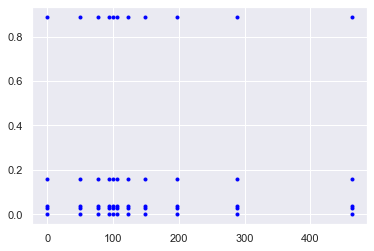

In [2443]:
Vec_s, Delta_s, Vec_v, Delta_v, X, Y = make_grid(m1, S, S_0, K, c, m2, V, V_0, d)
A_0, A_1, A_2, A = make_matrices(m1, m2, m, rho, sigma, r_d, r_f, kappa, eta, Vec_s, Vec_v, Delta_s, Delta_v)
B_0, B_1, B_2, B = make_boundaries(m1, m2, m, r_d, r_f, N, Vec_s, delta_t)

In [2444]:
# pricing
print("--True Price", true_price)

--True Price 8.894869360054017


In [2445]:
print("\n--CN Scheme")
theta = 0.8
UU_0 = np.array([[max(Vec_s[i] - K, 0) for i in range(m1 + 1)] for j in range(m2 + 1)])
U_0 = UU_0.flatten()
price, time = CN_scheme(m, N, U_0, delta_t, A, B, r_f)
price = np.reshape(price, (m2 + 1, m1 + 1))
index_s = Vec_s.index(S_0)
index_v = Vec_v.index(V_0)

print(" S_0: ", Vec_s[index_s])
print(" V_0: ", Vec_v[index_v])
print(" price: ", price[index_v, index_s])
print(" Error: ", abs(price[index_v, index_s] - true_price) / true_price)
print(" Computation Time: ", time)


--CN Scheme
 S_0:  100
 V_0:  0.04
 price:  8.754301096062914
 Error:  0.01580329719314159
 Computation Time:  0.021967


In [2446]:
print("\n--Do Scheme")
theta = 0.8
UU_0 = np.array([[max(Vec_s[i] - K, 0) for i in range(m1 + 1)] for j in range(m2 + 1)])
U_0 = UU_0.flatten()

price, time = DO_scheme(m, N, U_0, delta_t, theta, A, A_0, A_1, A_2, B, B_0, B_1, B_2, r_f)
price = np.reshape(price, (m2 + 1, m1 + 1))
index_s = Vec_s.index(S_0)
index_v = Vec_v.index(V_0)

print(" S_0: ", Vec_s[index_s])
print(" V_0: ", Vec_v[index_v])
print(" price: ", price[index_v, index_s])
print(" Error: ", abs(price[index_v, index_s] - true_price) / true_price)
print(" Computation Time: ", time)


--Do Scheme
 S_0:  100
 V_0:  0.04
 price:  8.745572735205274
 Error:  0.01678457758123121
 Computation Time:  0.031941


Panel Data

In [2573]:
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
from linearmodels.datasets import wage_panel
import pandas as pd

data = wage_panel.load()
data = data.set_index(['nr', 'year'])
exog_vars = ['married']
exog = data[exog_vars]

mod = PanelOLS(data.lwage, exog)
fe_res = mod.fit()

mod = PooledOLS(data.lwage, exog)
pooled_res = mod.fit()

mod = PanelOLS(data.lwage, exog, time_effects=True, entity_effects=True)
fe_res = mod.fit()
fe_res_cluster = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

In [2574]:
fe_res

Dep. Variable:,lwage,R-squared:,0.0028
Estimator:,PanelOLS,R-squared (Between):,0.0313
No. Observations:,4360,R-squared (Within):,0.0205
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.0309
Time:,16:50:12,Log-likelihood,-1366.2
Cov. Estimator:,Unadjusted,,
,,F-statistic:,10.838
Entities:,545,P-value,0.0010
Avg Obs:,8.0000,Distribution:,"F(1,3807)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,10.838


In [2575]:
fe_res_cluster

Dep. Variable:,lwage,R-squared:,0.0028
Estimator:,PanelOLS,R-squared (Between):,0.0313
No. Observations:,4360,R-squared (Within):,0.0205
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.0309
Time:,16:50:12,Log-likelihood,-1366.2
Cov. Estimator:,Clustered,,
,,F-statistic:,10.838
Entities:,545,P-value,0.0010
Avg Obs:,8.0000,Distribution:,"F(1,3807)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,13.791


In [2572]:
pooled_res

Dep. Variable:,lwage,R-squared:,0.4594
Estimator:,PooledOLS,R-squared (Between):,0.5635
No. Observations:,4360,R-squared (Within):,-1.8212
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4594
Time:,16:36:04,Log-likelihood,-7243.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3703.6
Entities:,545,P-value,0.0000
Avg Obs:,8.0000,Distribution:,"F(1,4359)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,3703.6
